In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings

In [2]:
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score, confusion_matrix

In [16]:
warnings.filterwarnings("ignore")

In [11]:
df=pd.read_csv("EnronSpamData.csv",index_col="Message ID")
df.head()

,Subject,Message,Spam/Ham
Message ID,,,
0,christmas tree farm pictures,NaN,ham
1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,re : issue,fyi - see note below - already done .\nstella\...,ham
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham


In [12]:
#df=df.sample(n = 15000)
df.rename(columns={'Spam/Ham':"isImportant"}, inplace=True)
df["isImportant"]=df.isImportant.map(dict(ham=True, spam=False))
df["CombinedMessage"] = df["Subject"].astype(str) +" " + df["Message"].astype(str)
df.drop(["Subject","Message"],axis=1,inplace=True)
df = df[['CombinedMessage', 'isImportant']]
df.head()

,CombinedMessage,isImportant
Message ID,,
0,christmas tree farm pictures nan,True
1,"vastar resources , inc . gary , production fro...",True
2,calpine daily gas nomination - calpine daily g...,True
3,re : issue fyi - see note below - already done...,True
4,meter 7268 nov allocation fyi .\n- - - - - - -...,True


In [13]:
df_Xtrain, df_Xtest = train_test_split(df, test_size=0.2,random_state=42,stratify=df["isImportant"], shuffle=True)
df_Xtest

,CombinedMessage,isImportant
Message ID,,
19075,"victory at last sat , 05 jun 2004 11 : 14 : 04...",False
16714,caiso notification - tswg conference call plea...,True
11264,ena balance sheet assets / responsibilities he...,True
3973,"you can start saving nab re - finance now , ev...",False
11103,"peaker update louise ,\nat your earliest conve...",True
...,...,...
32299,contact me . from mr . nicolas kaseko tel numb...,False
11173,ena commerical managers and above empl agrm st...,True
29806,assistance and investment ! mr : donald kabila...,False


In [7]:
vectorizer = CountVectorizer(stop_words="english", 
                             ngram_range=(1, 3))


In [8]:
term_document_matrix = vectorizer.fit_transform(df_Xtrain.CombinedMessage)
term_document_matrix

<26972x3507599 sparse matrix of type '<class 'numpy.int64'>'
	with 9167687 stored elements in Compressed Sparse Row format>

In [9]:
corpus = Sparse2Corpus(term_document_matrix, documents_columns=False)
corpus.sparse

<3507599x26972 sparse matrix of type '<class 'numpy.int64'>'
	with 9167687 stored elements in Compressed Sparse Column format>

In [10]:
id2word = {value: key for key, value in vectorizer.vocabulary_.items()}
id2word

{1098542: 'don',
 1836383: 'know',
 2848831: 'search',
 1213739: 'engine',
 2743018: 'results',
 3070181: 'submitting',
 3402382: 'website',
 1214691: 'engines',
 1684390: 'increase',
 2288658: 'online',
 2814549: 'sales',
 1114290: 'dramatically',
 1746175: 'invested',
 3186693: 'time',
 2133668: 'money',
 2936594: 'simply',
 3069342: 'submit',
 3428523: 'wiii',
 1754004: 'invisibie',
 3359717: 'virtually',
 2053468: 'means',
 1168262: 'efforts',
 2994188: 'spent',
 3326142: 'vain',
 1898009: 'lf',
 3381122: 'want',
 2388004: 'people',
 555022: 'boost',
 2752037: 'revenues',
 3394087: 'way',
 1996213: 'make',
 2942621: 'site',
 3360678: 'visible',
 2420468: 'piaces',
 2387988: 'peopie',
 1705056: 'information',
 2163105: 'muitiple',
 3390836: 'watch',
 3362868: 'visitors',
 3049475: 'stream',
 595401: 'business',
 510888: 'best',
 2715771: 'reqards',
 1984043: 'magdalenefranks',
 1731053: 'interested',
 1099583: 'don know',
 1841262: 'know search',
 2848994: 'search engine',
 1213914:

In [11]:
model = LdaModel(corpus=corpus, 
                 id2word=id2word, 
                 random_state=0)
model

In [12]:
def transform_messages_to_topic_vectors(data, vectorizer, model):
    num_topics = model.num_topics
    message_topics = pd.DataFrame(index=map(str, range(num_topics)))    
    for index, message in data.CombinedMessage.iteritems():
        message_transformed = (vectorizer.transform([message]))
        message_corpus = (Sparse2Corpus(message_transformed, documents_columns=False))
        topics_framework = dict.fromkeys(map(str, range(0, num_topics)))
        topics_specific = dict(list(model[message_corpus])[0])
        for key in topics_specific:
            topics_framework[str(key)] = topics_specific[key]
        message_topics[index] = pd.Series(topics_framework)
    message_topics = message_topics.T.fillna(0)
    data = data.join(message_topics)
    data.drop("CombinedMessage", axis=1, inplace=True)
    data = pd.get_dummies(data, drop_first=True)
    #data.rename(columns=dict(Class_spam="Spam"), inplace=True)
    return data

In [13]:
train = transform_messages_to_topic_vectors(df_Xtrain, vectorizer, model)
#test = transform_messages_to_topic_vectors(test, vectorizer, model)
train.head()

,isImportant,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
Message ID,,,,,,,,,,,,,,,,,,,,,
26082,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0
10033,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.01418,0.0,0.0,0.0
6768,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.04646,0.0,0.00000,0.0,0.0,0.0
1759,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.019983,0.244442,0.00000,0.0,0.00000,0.0,0.0,0.0
33533,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0


In [14]:
test = transform_messages_to_topic_vectors(df_Xtest, vectorizer, model)
test.head()

,isImportant,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
Message ID,,,,,,,,,,,,,,,,,,,,,
19075,False,0.0,0.0,0.0,0.073604,0.0,0.0,0.024751,0.0,0.0,...,0.000000,0.0,0.105339,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16714,True,0.0,0.0,0.0,0.000000,0.0,0.0,0.203601,0.0,0.0,...,0.000000,0.0,0.148509,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11264,True,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.146406,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3973,False,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11103,True,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.046368,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


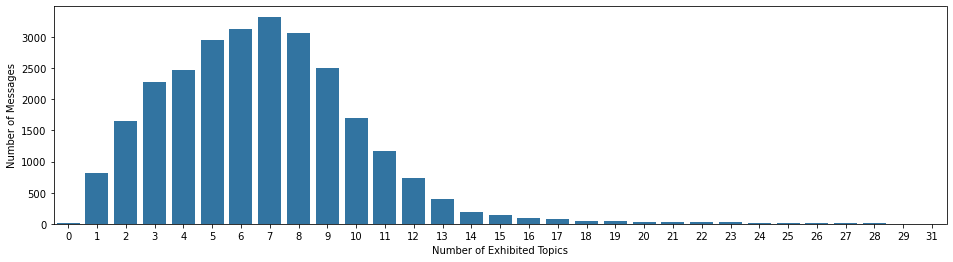

In [15]:
topics = list(train.columns)
topics.remove("isImportant")
ax = sns.countplot(train[topics].astype(bool).sum(axis=1), color="C0")
ax.set_xlabel("Number of Exhibited Topics")
ax.set_ylabel("Number of Messages")
fig = plt.gcf()
fig.set_size_inches(16, 4)

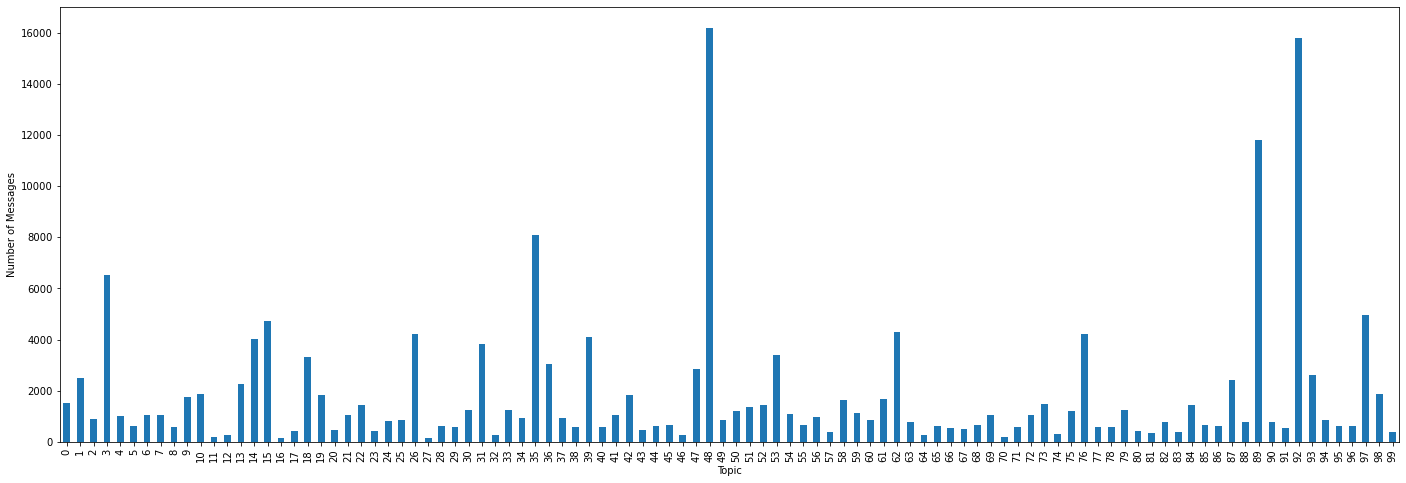

In [16]:
ax = train[topics].astype(bool).sum(axis=0).plot.bar(color="C0")
ax.set_xlabel("Topic")
ax.set_ylabel("Number of Messages")
fig = plt.gcf()
fig.set_size_inches(24, 8)

In [17]:
print("The most prevalent ngrams in the most prevalent topic are:\n- {}".format('\n- '.join([id2word[term[0]] for term in model.get_topic_terms(50)])))

The most prevalent ngrams in the most prevalent topic are:
- utf
- china
- ks
- free shipping
- world trade
- fancy
- 01 11
- cwtd
- aepin
- forbes


D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='isImportant', ylabel='count'>

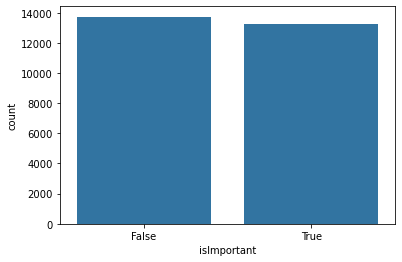

In [18]:
X_train = train.drop("isImportant", axis=1)
Y_train = train.isImportant
X_test = test.drop("isImportant", axis=1)
Y_test = test.isImportant
sns.countplot(Y_train, color="C0")

In [19]:
print("Number of important messages in the test set: {}"\
      .format(test["isImportant"].value_counts()[1]))

Number of important messages in the test set: 3309


In [20]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Message ID,,,,,,,,,,,,,,,,,,,,,
26082,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.0
10033,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.01418,0.000000,0.0,0.0
6768,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.04646,0.0,0.00000,0.000000,0.0,0.0
1759,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.019983,0.244442,0.00000,0.0,0.00000,0.000000,0.0,0.0
33533,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.680531,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9150,0.117266,0.000000,0.0,0.132320,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.285048,0.000000,0.00000,0.0,0.00000,0.032712,0.0,0.0
12177,0.000000,0.000000,0.0,0.023237,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.495420,0.000000,0.00000,0.0,0.00000,0.060069,0.0,0.0
3700,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.0


In [21]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Message ID,,,,,,,,,,,,,,,,,,,,,
19075,0.000000,0.0,0.0,0.073604,0.0,0.0,0.024751,0.0,0.0,0.0,...,0.000000,0.0,0.105339,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
16714,0.000000,0.0,0.0,0.000000,0.0,0.0,0.203601,0.0,0.0,0.0,...,0.000000,0.0,0.148509,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11264,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.146406,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3973,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11103,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.046368,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32299,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.100436,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11173,0.000000,0.0,0.0,0.111369,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
29806,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.230998,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [22]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

In [23]:
%%capture --no-stdout

param_grid = dict(C=np.logspace(-3, 3, 7))
best_C_linear = GridSearchCV(LinearSVC(class_weight="balanced", random_state=0), 
                             param_grid, 
                             cv=5).fit(X_train, Y_train)\
                                  .best_params_["C"]
print("The best value for the tuning parameter 'C' is {}.".format(best_C_linear))

The best value for the tuning parameter 'C' is 0.1.


In [24]:
svm_linear = LinearSVC(C=best_C_linear, 
                       random_state=0, 
                       max_iter=1e6).fit(X_train, Y_train)

In [25]:
priors = list(train.isImportant.value_counts().div(train.isImportant.value_counts().sum()))
nb = GaussianNB(priors).fit(X_train, Y_train)

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass priors=[0.5092688714222157, 0.4907311285777844] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [26]:
%%capture --no-stdout

param_grid["gamma"] = ["auto", "scale"]
best_svm_rbf_params = GridSearchCV(SVC(class_weight="balanced", 
                                       random_state=0, 
                                       max_iter=1000), 
                                   param_grid, 
                                   cv=5).fit(X_train, Y_train)\
                                        .best_params_
print("The best value for the tuning parameter 'C' is {}."\
      .format(best_svm_rbf_params["C"]))
print("The best value for 'gamma' is {}.".format(best_svm_rbf_params["gamma"]))

The best value for the tuning parameter 'C' is 10.0.
The best value for 'gamma' is auto.


In [27]:
svm_rbf = SVC(C=best_svm_rbf_params["C"], 
              gamma=best_svm_rbf_params["gamma"], 
              random_state=0, 
              max_iter=-1).fit(X_train, Y_train)

In [28]:
classifiers = [("svm_linear", svm_linear), 
               ("nb", nb), 
               ("svm_rbf", svm_rbf)]
ensemble = VotingClassifier(classifiers).fit(X_train, Y_train)

In [29]:
svm_linear_score = svm_linear.score(X_test, Y_test)
nb_score = nb.score(X_test, Y_test)
svm_rbf_score = svm_rbf.score(X_test, Y_test)
ensemble_score = ensemble.score(X_test, Y_test)

print("The linear SVM has a test accuracy score of {:.3f}.".format(svm_linear_score))
print("The Gaussian naive Bayes classifer has a test accuracy score of {:.3f}."\
      .format(nb_score))
print("The SVM with an RBF kernel has a test accuracy score of {:.3f}."\
      .format(svm_rbf_score))
print("The ensemble voting classifier has a test accuracy score of {:.3f}."\
      .format(ensemble_score))

The linear SVM has a test accuracy score of 0.949.
The Gaussian naive Bayes classifer has a test accuracy score of 0.807.
The SVM with an RBF kernel has a test accuracy score of 0.966.
The ensemble voting classifier has a test accuracy score of 0.950.


In [30]:
ensemble_score = ensemble.score(X_test, Y_test)

In [31]:
dummy_constant = DummyClassifier("constant", 
                                 random_state=0, 
                                 constant=0).fit(X_train, Y_train)
dummy_constant_score = dummy_constant.score(X_test, Y_test)

print("The dummy constant classifier has a test accuracy score of {:.3f}."\
      .format(dummy_constant_score))

The dummy constant classifier has a test accuracy score of 0.509.


D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass strategy=constant as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [32]:
dummy_constant_preds = dummy_constant.predict(X_test)
svm_linear_preds = svm_linear.predict(X_test)
nb_preds = nb.predict(X_test)
svm_rbf_preds = svm_rbf.predict(X_test)
ensemble_preds = ensemble.predict(X_test)

dummy_constant_score = average_precision_score(Y_test, dummy_constant_preds)
svm_linear_score = average_precision_score(Y_test, svm_linear_preds)
nb_score = average_precision_score(Y_test, nb_preds)
svm_rbf_score = average_precision_score(Y_test, svm_rbf_preds)
ensemble_score = average_precision_score(Y_test, ensemble_preds)

print("The dummy constant classifier has a test average precision score of {:.3f}."\
      .format(dummy_constant_score))
print("The linear SVM has a test average precision score of {:.3f}.".format(svm_linear_score))
print("The Gaussian naive Bayes classifer has a test average precision score of {:.3f}."\
      .format(nb_score))
print("The SVM with an RBF kernel has a test average precision score of {:.3f}."\
      .format(svm_rbf_score))
print("The ensemble voting classifier has a test average precision score of {:.3f}."\
      .format(ensemble_score))

The dummy constant classifier has a test average precision score of 0.491.
The linear SVM has a test average precision score of 0.924.
The Gaussian naive Bayes classifer has a test average precision score of 0.723.
The SVM with an RBF kernel has a test average precision score of 0.951.
The ensemble voting classifier has a test average precision score of 0.924.


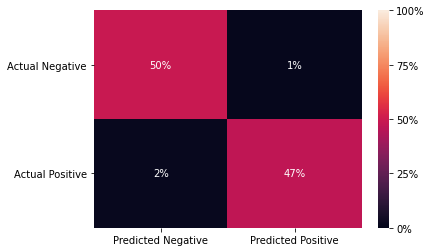

In [33]:
confusion = pd.DataFrame(confusion_matrix(Y_test, svm_rbf_preds))
confusion = confusion.div(confusion.sum().sum())
confusion.columns = ["Predicted Negative", "Predicted Positive"]
confusion.index = ["Actual Negative", "Actual Positive"]
ax = sns.heatmap(confusion, vmin=0, vmax=1, annot=True, fmt=".0%")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.collections[0].colorbar.set_ticks((0, .25, .5, .75, 1))
ax.collections[0].colorbar.set_ticklabels(("0%", "25%", "50%", "75%", "100%"))

In [34]:
confusion

,Predicted Negative,Predicted Positive
Actual Negative,0.495107,0.014235
Actual Positive,0.019870,0.470789


In [35]:
 svm_rbf_preds

array([ True,  True,  True, ..., False,  True,  True])

In [36]:
Y_test

Message ID
19075    False
16714     True
11264     True
3973     False
11103     True
         ...  
32299    False
11173     True
29806    False
22832     True
5305      True
Name: isImportant, Length: 6744, dtype: bool

In [37]:
df_syn = pd.read_csv("MailBodyOutput_latest.csv",index_col="ID")

In [38]:
df_syn.drop(["to","from_"],axis=1,inplace=True)
df_syn.rename(columns={'body':"CombinedMessage"}, inplace=True)
df_syn = df_syn[df_syn["CombinedMessage"].notna()]
df_syn

,CombinedMessage
ID,
A1,"Welcome to your Google Account\nHi Dmml,\nWelc..."
A2,"Your impartial, comprehensive news source.\nHe..."
A3,Welcome to The Morning newsletter\nWe'll bring...
A4,Thanks for signing up for Morning Brew\nToday ...
A5,NextDraft\nImportant: Confirm Your Subscriptio...
...,...
A3068,Hi [Name]\nI’m a big fan of your company. You ...
A3069,Hi [Name]\nI have been following you on [socia...
A3070,Hi [Name]\nThank you for signing up for the fr...


In [39]:
test_syn = transform_messages_to_topic_vectors(df_syn, vectorizer, model)
test_syn.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ID,,,,,,,,,,,,,,,,,,,,,
A1,0.0,0.0,0.020932,0.047717,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.038157,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
A2,0.0,0.0,0.000000,0.026444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.230102,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
A3,0.0,0.0,0.000000,0.021536,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.284544,0.0,0.011036,0.0,0.0,0.00000,0.0,0.0
A4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.220561,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
A5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.02861,0.0,0.0


In [40]:
svm_rbf_preds = svm_rbf.predict(test_syn)

In [41]:
svm_rbf_preds

array([False, False,  True, ..., False, False,  True])

In [42]:
test_syn.index

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       ...
       'A3063', 'A3064', 'A3065', 'A3066', 'A3067', 'A3068', 'A3069', 'A3070',
       'A3071', 'A3072'],
      dtype='object', name='ID', length=3061)

In [43]:
df_TMOutput = pd.DataFrame(
    {'ID': test_syn.index,
     'isImportant': svm_rbf_preds
    })
df_TMOutput.to_csv("TM_LDA_output.csv",index=False)